In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import pandas as pd


import os
print(os.getcwd())
path = str(os.getcwd())
path = path.replace('\\economic_data\\notebooks', "")
path = path.replace('\\', "/")

c:\programowanie\bond\economic_data\notebooks


In [36]:
df = pd.read_csv(path + "/economic_data/raw_data/NBP.csv", delimiter=";")


df["date"] = [(str(i).replace(".", "/")) for i in df["date"]]

df["date"] = pd.to_datetime(df["date"], format="%d/%m/%Y")
df["month"] = df["date"].dt.month
df["year"] = df["date"].dt.year
df.drop("date", axis=1, inplace=True)
df = df.drop_duplicates(["month","year"])

df.head()

,interest_rate,month,year
0,24,2,1998
1,23,4,1998
2,"21,5",5,1998
3,19,7,1998
4,18,9,1998


In [37]:
date_series = pd.DataFrame({"date" : pd.date_range(start='1998/02/01', end='2023/08/09', freq='M')})
date_series['interest_rate'] = 0
date_series["month"] = date_series["date"].dt.month
date_series["year"] = date_series["date"].dt.year
date_series.drop("date", axis=1, inplace=True)

date_series

,interest_rate,month,year
0,0,2,1998
1,0,3,1998
2,0,4,1998
3,0,5,1998
4,0,6,1998
...,...,...,...
301,0,3,2023
302,0,4,2023
303,0,5,2023
304,0,6,2023


In [38]:
date_series = date_series.merge(df, on=["month", "year"], how="left")

date_series.drop(["interest_rate_x"], axis=1, inplace=True)
#date_series.value_counts("interest_rate")

date_series.tail()

,month,year,interest_rate_y
301,3,2023,NaN
302,4,2023,NaN
303,5,2023,NaN
304,6,2023,NaN
305,7,2023,NaN


In [39]:

date_series["interest_rate_y"] = [float(str(i).replace(",", ".")) for i in date_series["interest_rate_y"]]
df_full = date_series.fillna(method='ffill')

df_full.rename(columns = {'interest_rate_y' : 'interest_rate'}, inplace = True)

df_full.tail()

,month,year,interest_rate
301,3,2023,6.75
302,4,2023,6.75
303,5,2023,6.75
304,6,2023,6.75
305,7,2023,6.75


In [40]:
df_full.to_csv(path + "/economic_data/NBP.csv", index=False)

df = df_full.copy()
df["date"] =  pd.to_datetime(df["year"].astype(str) + "-" + df["month"].astype(str) + "-1", format='%Y-%m-%d')
#df = df[df["year"] >= 2000]

df.drop(["month", "year"], axis = 1,inplace = True)

df.set_index('date', inplace=True)

### MODEL ###

In [41]:
train = df_full.copy()
inflation_pred = pd.read_csv(path + "/economic_data/predicted_inflation.csv")
histInflation = pd.read_csv(path + "/economic_data/inflation_gus.csv")

histInflation["date"] = pd.to_datetime(histInflation["date"])

histInflation["month"] = histInflation["date"].dt.month
histInflation["year"] = histInflation["date"].dt.year
histInflation.drop("date", axis=1, inplace=True)



train = train.merge(histInflation, on=["month", "year"], how="left")
data = train.copy()
train

,month,year,interest_rate,inflation
0,2,1998,24.00,14.2
1,3,1998,24.00,13.9
2,4,1998,23.00,13.7
3,5,1998,21.50,13.3
4,6,1998,21.50,12.2
...,...,...,...,...
301,3,2023,6.75,16.1
302,4,2023,6.75,14.7
303,5,2023,6.75,13.0
304,6,2023,6.75,11.5


In [42]:
plot_df = data[data["year"] > 2002]
plot_df

,month,year,interest_rate,inflation
59,1,2003,6.50,0.5
60,2,2003,6.25,0.5
61,3,2003,6.00,0.6
62,4,2003,5.75,0.3
63,5,2003,5.50,0.4
...,...,...,...,...
301,3,2023,6.75,16.1
302,4,2023,6.75,14.7
303,5,2023,6.75,13.0
304,6,2023,6.75,11.5


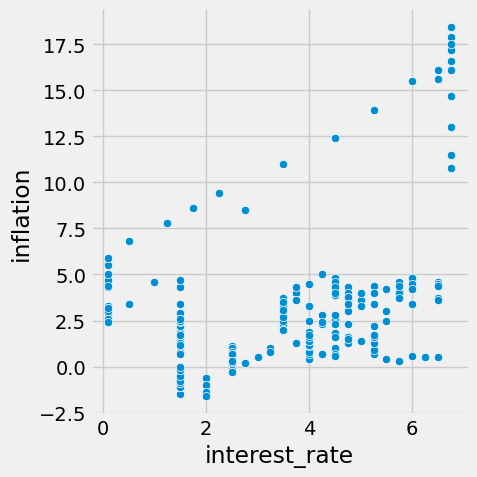

In [43]:
sns.relplot(data = plot_df, y = "inflation", x = "interest_rate")

C:\Users\proso\AppData\Local\Temp\ipykernel_2564\2238889535.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['highInflation'] = np.where(train_data['inflation'] > 5, 1, 0)


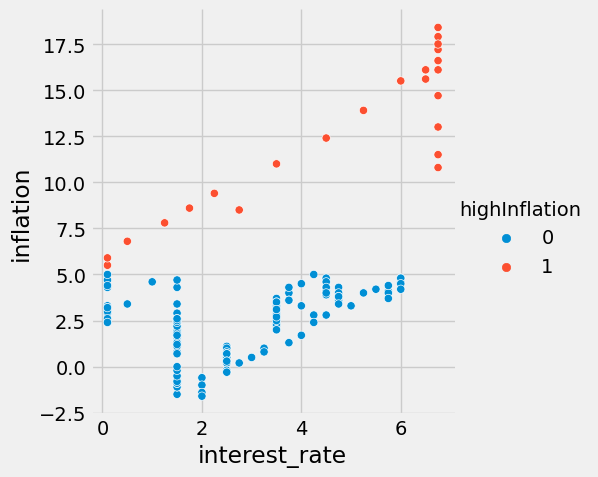

In [44]:
train_data = data[data["year"] > 2007]
train_data['highInflation'] = np.where(train_data['inflation'] > 5, 1, 0)
sns.relplot(data = train_data, y = "inflation", x = "interest_rate", hue="highInflation")

In [45]:
with pd.option_context('mode.chained_assignment', None):

    for i in range(2000, 2023):

        train_data = data[data["year"] > i]
        train_data['highInflation'] = np.where(train_data['inflation'] > 5, 1, 0)
        results = smf.ols('interest_rate ~ inflation + highInflation', data=train_data).fit()
        print("R2: ", results.rsquared, " | year = ", i)

R2:  0.17115787432846485  | year =  2000
R2:  0.18576056710251432  | year =  2001
R2:  0.2663560756526059  | year =  2002
R2:  0.34375884936470735  | year =  2003
R2:  0.3462006448047945  | year =  2004
R2:  0.38389723123867436  | year =  2005
R2:  0.4299121857474283  | year =  2006
R2:  0.4559372511260602  | year =  2007
R2:  0.4715395843274832  | year =  2008
R2:  0.47454775679202477  | year =  2009
R2:  0.4900478253969969  | year =  2010
R2:  0.4968195691922255  | year =  2011
R2:  0.5664541155530436  | year =  2012
R2:  0.6310630714360971  | year =  2013
R2:  0.6906747011087578  | year =  2014
R2:  0.7327203433679932  | year =  2015
R2:  0.7946033706250362  | year =  2016
R2:  0.8080452696677483  | year =  2017
R2:  0.8474623883260228  | year =  2018
R2:  0.9129099893350228  | year =  2019
R2:  0.8888439932448535  | year =  2020
R2:  0.5532066711494369  | year =  2021
R2:  -inf  | year =  2022


c:\Users\proso\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


C:\Users\proso\AppData\Local\Temp\ipykernel_2564\4233868803.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['highInflation'] = np.where(train_data['inflation'] > 5, 1, 0)


                            OLS Regression Results                            
Dep. Variable:          interest_rate   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     144.4
Date:                Wed, 20 Sep 2023   Prob (F-statistic):           5.86e-22
Time:                        18:21:47   Log-Likelihood:                -79.476
No. Observations:                  55   AIC:                             165.0
Df Residuals:                      52   BIC:                             171.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.7444      0.247     -3.015

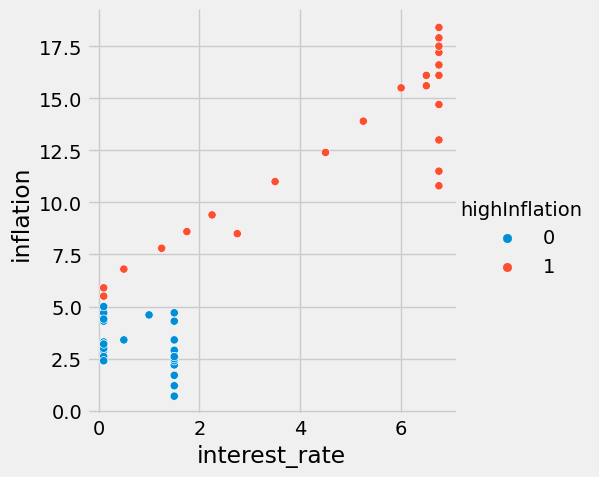

In [46]:
train_data = data[data["year"] > 2018]
train_data['highInflation'] = np.where(train_data['inflation'] > 5, 1, 0)
sns.relplot(data = train_data, y = "inflation", x = "interest_rate", hue="highInflation")
results = smf.ols('interest_rate ~ inflation + highInflation', data=train_data).fit()

# Inspect the resul
print(results.summary())
print("Parameters: ", results.params)
print("R2: ", results.rsquared, " | year = ", i)

In [47]:
pred_index = pd.DataFrame({"date" :pd.date_range(df.index[-1], periods = 144, freq='MS')})
pred_index["month"] = pred_index["date"].dt.month
pred_index["year"] = pred_index["date"].dt.year
pred_index.set_index("date", inplace=True)

pred_index["inflation"] = np.asarray(inflation_pred["inflation"])
pred_index['highInflation'] = np.where(pred_index['inflation'] > 5, 1, 0)

In [48]:
pred = results.predict(pred_index[["inflation", "highInflation"]])
pred_index["rates"] = pred + 3
pred_index

,month,year,inflation,highInflation,rates
date,,,,,
2023-07-01,7,2023,9.82,1,6.322796
2023-08-01,8,2023,8.72,1,5.778281
2023-09-01,9,2023,7.59,1,5.218915
2023-10-01,10,2023,6.48,1,4.669450
2023-11-01,11,2023,5.41,1,4.139785
...,...,...,...,...,...
2035-02-01,2,2035,0.93,0,2.715982
2035-03-01,3,2035,0.85,0,2.676381
2035-04-01,4,2035,0.76,0,2.631829


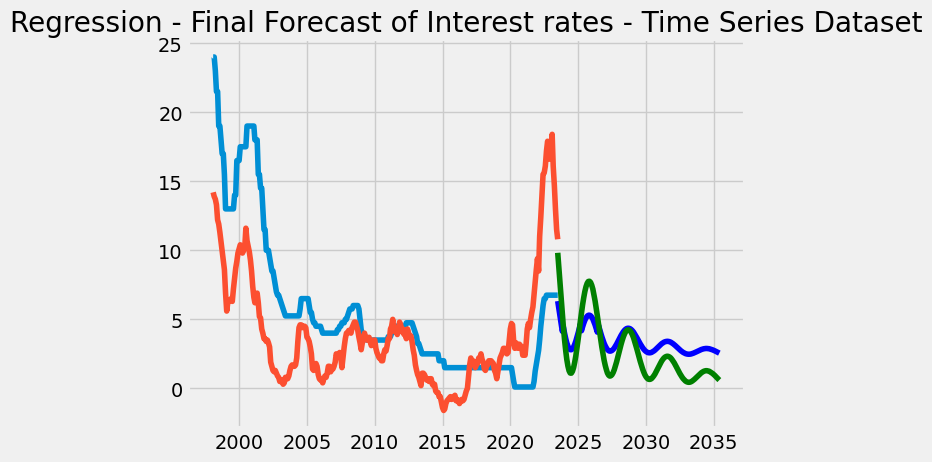

In [49]:
data["date"] =  pd.to_datetime(data["year"].astype(str) + "-" + data["month"].astype(str) + "-1", format='%Y-%m-%d')
data.set_index("date", inplace = True)

plt.plot(df)
plt.plot(data["inflation"])
plt.plot(pred_index["rates"], color='blue')
plt.plot(pred_index["inflation"], color='green')

plt.title("Regression - Final Forecast of Interest rates - Time Series Dataset")
plt.show()